In [ ]:
# https://datalemur.com/questions/sql-top-three-salaries

"""
WITH employee_ranked_cte AS (
  SELECT
    *,
    DENSE_RANK() OVER (PARTITION BY department_id ORDER BY salary DESC) AS salary_rank
  FROM employee 
)

SELECT 
  d.department_name,
  er.name,
  er.salary
FROM employee_ranked_cte er
LEFT JOIN department d
  ON d.department_id = er.department_id
WHERE salary_rank <= 3
ORDER BY d.department_name, er.salary DESC, er.name
"""

In [ ]:
# https://datalemur.com/questions/sql-highest-grossing

"""
WITH cte AS (
  SELECT 
    category,
    product,
    SUM(spend) AS total_spend,
    RANK() OVER (PARTITION BY category ORDER BY SUM(spend) DESC) AS product_rank
  FROM product_spend
  WHERE EXTRACT(YEAR FROM transaction_date) = 2022
  GROUP BY category, product
)

SELECT 
  category,
  product,
  total_spend
FROM cte
WHERE product_rank <= 2;
"""


In [ ]:
# https://datalemur.com/questions/rolling-average-tweets

"""
WITH ranked_cte AS (
  SELECT
    *,
    RANK() OVER (
      PARTITION BY user_id
      ORDER BY tweet_date
    ) AS rank_bucket
  FROM tweets
),
lag_cte AS (
  SELECT
    *,
    COALESCE(LAG(tweet_count, 1) OVER (
      PARTITION BY user_id
      ORDER BY tweet_date
    ), 0) AS lag_1,
    COALESCE(LAG(tweet_count, 2) OVER (
      PARTITION BY user_id
      ORDER BY tweet_date
    ), 0) AS lag_2,
    CASE
      WHEN rank_bucket = 1 THEN 1
      WHEN rank_bucket = 2 THEN 2
      WHEN rank_bucket >= 3 THEN 3
    END AS counter
  FROM ranked_cte
)

SELECT
  user_id,
  tweet_date,
  ROUND((tweet_count + lag_1 + lag_2) / (counter * 1.0), 2) AS rolling_avg_3d
FROM lag_cte;
"""

# A fancy way of doing the same:

"""
SELECT    
  user_id,    
  tweet_date,   
  ROUND(AVG(tweet_count) OVER (
    PARTITION BY user_id     
    ORDER BY tweet_date     
    ROWS BETWEEN 2 PRECEDING AND CURRENT ROW)
  ,2) AS rolling_avg_3d
FROM tweets;
"""

In [ ]:
# https://datalemur.com/questions/time-spent-snaps

"""
WITH total_aggregate_cte AS (
  SELECT
    ab.age_bucket,
    SUM(a.time_spent) total_activity_time
  FROM activities a
  LEFT JOIN age_breakdown ab
    ON a.user_id = ab.user_id
  WHERE activity_type IN ('open', 'send')
  GROUP BY
    ab.age_bucket
),
send_aggregate_cte AS (
  SELECT
    ab.age_bucket,
    SUM(a.time_spent) send_activity_time
  FROM activities a
  LEFT JOIN age_breakdown ab
    ON a.user_id = ab.user_id
  WHERE activity_type = 'send'
  GROUP BY
    ab.age_bucket
),
open_aggregate_cte AS (
  SELECT
    ab.age_bucket,
    SUM(a.time_spent) open_activity_time
  FROM activities a
  LEFT JOIN age_breakdown ab
    ON a.user_id = ab.user_id
  WHERE activity_type = 'open'
  GROUP BY
    ab.age_bucket
)

SELECT 
  t.age_bucket,
  ROUND(s.send_activity_time / t.total_activity_time * 100.0, 2) AS send_perc,
  ROUND(o.open_activity_time / t.total_activity_time * 100.0, 2) AS open_perc
FROM total_aggregate_cte t
  LEFT JOIN send_aggregate_cte s
    ON s.age_bucket = t.age_bucket
  LEFT JOIN open_aggregate_cte o
    ON o.age_bucket = t.age_bucket;
"""

# A shorter select with filter per SUM is possible!

"""
SELECT 
  age.age_bucket, 
  ROUND(100.0 * 
    SUM(activities.time_spent) FILTER (WHERE activities.activity_type = 'send')/
    SUM(activities.time_spent),2) AS send_perc, 
  ROUND(100.0 * 
    SUM(activities.time_spent) FILTER (WHERE activities.activity_type = 'open')/
    SUM(activities.time_spent),2) AS open_perc
FROM activities
INNER JOIN age_breakdown AS age 
  ON activities.user_id = age.user_id 
WHERE activities.activity_type IN ('send', 'open') 
GROUP BY age.age_bucket;
"""

In [ ]:
# https://datalemur.com/questions/sql-second-highest-salary

"""
WITH salaries_ranked_cte AS (
SELECT
    salary,
    DENSE_RANK() OVER (ORDER BY salary DESC) AS ranking
FROM employee
)

SELECT DISTINCT salary
FROM salaries_ranked_cte
WHERE ranking = 2;
"""

# For such a simple query, ranking the whole table could be skipped

"""
SELECT MAX(salary) AS second_highest_salary
FROM employee
WHERE salary < (
    SELECT MAX(salary)
    FROM employee
);
"""

In [ ]:
# https://datalemur.com/questions/sql-third-transaction

"""
WITH ranked_cte AS (
  SELECT
    user_id,
    spend,
    transaction_date,
    RANK() OVER (PARTITION BY user_id ORDER BY transaction_date ASC) AS order_no
  FROM transactions
)

SELECT 
  user_id,
  spend,
  transaction_date
FROM ranked_cte
WHERE order_no = 3;
"""

In [ ]:
# https://datalemur.com/questions/frequent-callers

"""
SELECT COUNT(policy_holder_id)
FROM (
  SELECT 
    policy_holder_id,
    COUNT(case_id) AS call_count
  FROM callers
  GROUP BY policy_holder_id
) pc
WHERE call_count >= 3;
"""

In [ ]:
# https://datalemur.com/questions/non-profitable-drugs

"""
SELECT
  manufacturer,
  COUNT(drug),
  SUM(cogs - total_sales) AS total_loss
FROM pharmacy_sales
WHERE total_sales < cogs
GROUP BY manufacturer
ORDER BY total_loss DESC;
"""

In [ ]:
# https://datalemur.com/questions/final-account-balance

"""
WITH deposits_cte AS (
  SELECT account_id, SUM(amount) AS deposit_sum
  FROM transactions
  WHERE transaction_type = 'Deposit'
  GROUP BY account_id
),
withdrawal_cte AS (
  SELECT account_id, SUM(amount) AS withdrawal_sum
  FROM transactions
  WHERE transaction_type = 'Withdrawal'
  GROUP BY account_id
)

SELECT d.account_id, d.deposit_sum - w.withdrawal_sum as final_balance
FROM deposits_cte d
  JOIN withdrawal_cte w
  ON d.account_id = w.account_id;
"""

# CASE WHEN makes it simple

"""
SELECT
  account_id,
  SUM(
    CASE 
      WHEN transaction_type = 'Deposit' THEN amount
      ELSE -amount END
  ) AS final_balance
FROM transactions
GROUP BY account_id;
"""

In [ ]:
# https://datalemur.com/questions/alibaba-compressed-mean

"""
SELECT ROUND((SUM(item_count * order_occurrences) / SUM(order_occurrences))::numeric, 1) AS mean
FROM items_per_order;
"""

In [ ]:
# https://datalemur.com/questions/cards-issued-difference

"""
SELECT card_name, MAX(issued_amount) - MIN(issued_amount) AS difference
FROM monthly_cards_issued
GROUP BY card_name
ORDER BY difference DESC;
"""

In [ ]:
# https://datalemur.com/questions/sql-ibm-db2-product-analytics

"""
WITH employee_query_count_cte AS (
  SELECT employee_id, COUNT(DISTINCT query_id) unique_queries
  FROM queries
  WHERE query_starttime >= '2023-07-01'
    AND query_starttime < '2023-10-01'
  GROUP BY employee_id
),
  
full_query_count_cte AS (
  SELECT *
  FROM employee_query_count_cte
  
  UNION ALL
  
  SELECT e.employee_id, 0 unique_queries
  FROM employees e
    LEFT JOIN employee_query_count_cte cte
    ON e.employee_id = cte.employee_id
    WHERE cte.employee_id IS NULL
  
  ORDER BY unique_queries
)

SELECT unique_queries, COUNT(employee_id) AS employee_count
FROM full_query_count_cte
GROUP BY unique_queries
ORDER BY unique_queries;
"""

# COALESCE allows doing one cte

"""
WITH employee_queries AS (
  SELECT 
    e.employee_id,
    COALESCE(COUNT(DISTINCT q.query_id), 0) AS unique_queries
  FROM employees AS e
  LEFT JOIN queries AS q
    ON e.employee_id = q.employee_id
      AND q.query_starttime >= '2023-07-01T00:00:00Z'
      AND q.query_starttime < '2023-10-01T00:00:00Z'
  GROUP BY e.employee_id
)

SELECT
  unique_queries,
  COUNT(employee_id) AS employee_count
FROM employee_queries
GROUP BY unique_queries
ORDER BY unique_queries;
"""

In [ ]:
# https://datalemur.com/questions/click-through-rate

"""
WITH 
  click_cte AS (
  SELECT app_id, COUNT(event_type) as click_count
  FROM events
  WHERE event_type = 'click' AND extract(YEAR FROM timestamp) = 2022
  GROUP BY app_id
  ),
  impression_cte AS (
  SELECT app_id, COUNT(event_type) as impression_count
  FROM events
  WHERE event_type = 'impression' AND extract(YEAR FROM timestamp) = 2022
  GROUP BY app_id
  )

SELECT DISTINCT
  e.app_id,
  ROUND(100.0 * c.click_count / i.impression_count, 2) as ctr
FROM events e
  LEFT JOIN click_cte c 
    ON c.app_id = e.app_id
  LEFT JOIN impression_cte i 
    ON i.app_id = e.app_id
"""

# No need for separate CTEs

"""
SELECT app_id, ROUND(100.0 *
    COUNT(1) FILTER (WHERE event_type = 'click') /
    COUNT(1) FILTER (WHERE event_type = 'impression'), 2) AS ctr
FROM events
WHERE EXTRACT(year FROM timestamp) = 2022
GROUP BY app_id
"""

In [ ]:
# https://datalemur.com/questions/sql-avg-review-ratings

"""
SELECT 
    EXTRACT(MONTH FROM submit_date) as mm,
    ROUND(avg(stars), 2) as avg_stars,
    product_id
FROM reviews
GROUP BY mm, product_id
ORDER BY mm, product_id;
"""

In [ ]:
# https://datalemur.com/questions/duplicate-job-listings

"""
WITH duped_companies_cte AS (SELECT DISTINCT company_id
FROM job_listings
GROUP BY (company_id, title, description)
HAVING COUNT(*) > 1)

SELECT COUNT(*) as duplicate_companies
FROM duped_companies_cte;
"""

In [ ]:
# https://datalemur.com/questions/teams-power-users

"""
SELECT sender_id, COUNT(message_id) AS message_count
FROM messages
WHERE EXTRACT(YEAR FROM sent_date) = 2022
  AND EXTRACT(MONTH FROM sent_date) = 08
GROUP BY sender_id
ORDER BY message_count DESC
LIMIT 2;
"""

In [ ]:
# https://datalemur.com/questions/laptop-mobile-viewership

"""
SELECT
  (SELECT COUNT(*) FROM viewership WHERE device_type NOT IN ('tablet', 'phone')) AS laptop_views,
  (SELECT COUNT(*) FROM viewership WHERE device_type IN ('tablet', 'phone')) AS mobile_views;
"""

# FILTER allows for not quering the same table twice

"""
SELECT 
  COUNT(*) FILTER (WHERE device_type = 'laptop') AS laptop_views,
  COUNT(*) FILTER (WHERE device_type IN ('tablet', 'phone'))  AS mobile_views 
FROM viewership;
"""

In [ ]:
# https://datalemur.com/questions/sql-histogram-tweets

"""
WITH user_tweet_count_cte AS (
  SELECT COUNT(tweet_id) AS tweet_bucket
  FROM tweets
  WHERE EXTRACT(YEAR FROM tweet_date) = 2022
  GROUP BY user_id
)

SELECT tweet_bucket, COUNT(tweet_bucket) AS users_num
FROM user_tweet_count_cte
GROUP BY tweet_bucket;
"""

In [ ]:
# https://datalemur.com/questions/total-drugs-sales

"""
SELECT manufacturer, CONCAT('$', ROUND((SUM(total_sales) / 1000000))::VARCHAR, ' ', 'million') AS sale
FROM pharmacy_sales
GROUP BY manufacturer
ORDER BY SUM(total_sales) DESC;
"""

In [ ]:
# https://datalemur.com/questions/sql-lower-practice-exercise

"""
SELECT *
FROM customers
WHERE customer_name ~ 'son$'
  AND gender = 'Male'
  AND age = 20;
"""

# Technically more correct version:

"""
SELECT *
FROM customers
WHERE LOWER(customer_name) LIKE '%son'
  AND gender = 'Male'
  AND age = 20;
"""

"\nSELECT *\nFROM customers\nWHERE customer_name ~ 'son$'\n  AND gender = 'Male'\n  AND age = 20;\n"

In [2]:
# https://datalemur.com/questions/sql-page-with-no-likes

"""
WITH liked_pages_cte AS (SELECT p.page_id
  FROM pages p
  JOIN 
  (
  SELECT DISTINCT COUNT(*) OVER (PARTITION BY page_id) AS total_likes, page_id FROM page_likes
  ) pl
  ON p.page_id = pl.page_id)


SELECT page_id
FROM pages
EXCEPT 
SELECT page_id
FROM liked_pages_cte
ORDER BY page_id ASC;
"""

# A lot of unnecessary work, we are only looking for non-existent rows in page_likes. Though admittedly I did think page_likes could have NULL entries per page_id entry in page_likes

"""
SELECT p.page_id
FROM pages p 
LEFT JOIN page_likes pl
ON p.page_id = pl.page_id
WHERE pl.user_id IS NULL
ORDER BY p.page_id DESC;
"""
# A cleaner option, decreasing runtime due to not having to use a join

"""
SELECT page_id
FROM pages
WHERE page_id NOT IN(SELECT page_id FROM page_likes);
"""

# Best solution yet:
"""
SELECT page_id FROM pages
except 
SELECT page_id FROM page_likes;
"""


'\nSELECT page_id FROM pages\nexcept \nSELECT page_id FROM page_likes;\n'

In [ ]:
# https://datalemur.com/questions/sql-well-paid-employees

"""
SELECT e.employee_id, e.name as employee_name
FROM employee e
JOIN employee m ON e.manager_id = m.employee_id
WHERE e.salary > m.salary;
"""

In [ ]:
# https://datalemur.com/questions/yoy-growth-rate

"""
WITH user_transactions_cte AS (
  SELECT EXTRACT(YEAR FROM transaction_date) AS year,
  product_id,
  spend AS curr_year_spend,
  LAG(spend) OVER (PARTITION BY product_id ORDER BY EXTRACT(YEAR FROM transaction_date)) AS prev_year_spend
  FROM user_transactions
  )
  
SELECT 
  year,
  product_id,
  curr_year_spend,
  prev_year_spend,
  ROUND(((curr_year_spend - prev_year_spend) / prev_year_spend) * 100, 2) AS yoy_rate
FROM user_transactions_cte
ORDER BY product_id, year
"""

In [ ]:
# https://datalemur.com/questions/odd-even-measurements

"""
WITH measurement_parities AS (
  SELECT measurement_id, (measurement_time::date)::timestamp as measurement_day,
  MOD(ROW_NUMBER() OVER (PARTITION BY (measurement_time::date)::timestamp ORDER BY measurement_time), 2) AS parity,
  ROW_NUMBER() OVER (PARTITION BY (measurement_time::date)::timestamp ORDER BY measurement_time)
  FROM measurements
)

SELECT measurement_day, 
  SUM(CASE WHEN parity = 1 THEN measurement_value END) AS odd_sum,
  SUM(CASE WHEN parity = 0 THEN measurement_value END) AS even_sum
  FROM measurements m
  LEFT JOIN measurement_parities mp ON m.measurement_id = mp.measurement_id
  GROUP BY measurement_day
  ORDER BY measurement_day;
  """

In [ ]:
# https://datalemur.com/questions/histogram-users-purchases

"""
WITH user_recent_date AS 
(SELECT MAX(transaction_date) AS recent_date,
  user_id
FROM user_transactions
GROUP BY user_id)

SELECT DISTINCT transaction_date, ut.user_id, COUNT(*) as purchase_count
FROM user_transactions ut
LEFT JOIN user_recent_date urt ON ut.user_id = urt.user_id
WHERE ut.transaction_date = urt.recent_date
GROUP BY transaction_date, ut.user_id
ORDER BY transaction_date;
"""

# JOIN is INNER JOIN hence simplifying the logic a little bit:

"""
WITH user_recent_date AS 
(SELECT MAX(transaction_date) AS recent_date,
  user_id
FROM user_transactions
GROUP BY user_id)

SELECT DISTINCT transaction_date, ut.user_id, COUNT(*) as purchase_count
FROM user_transactions ut
JOIN user_recent_date urt ON ut.user_id = urt.user_id AND ut.transaction_date = urt.recent_date
GROUP BY transaction_date, ut.user_id
ORDER BY transaction_date;
"""

In [ ]:
# https://datalemur.com/questions/top-fans-rank

"""
WITH artist_appearances AS (SELECT a.artist_name, COUNT(*) AS n_appearances
FROM artists a
LEFT JOIN songs s ON a.artist_id = s.artist_id
LEFT JOIN global_song_rank gsr ON s.song_id = gsr.song_id
GROUP BY a.artist_name)

SELECT artist_name, artist_rank, n_appearances
FROM (SELECT artist_name, n_appearances, DENSE_RANK() OVER (ORDER BY n_appearances DESC) AS artist_rank
FROM artist_appearances) ranked_appearances
WHERE artist_rank <= 5
ORDER BY artist_rank;
"""

In [ ]:
# https://datalemur.com/questions/card-launch-success

"""
SELECT
  DISTINCT card_name,
  FIRST_VALUE(issued_amount) OVER (PARTITION BY card_name ORDER BY issue_year, issue_month) AS issued_amount
  FROM monthly_cards_issued
  ORDER BY issued_amount DESC;
"""

In [ ]:
# https://datalemur.com/questions/sql-swapped-food-delivery

"""
WITH rank_cte AS (
SELECT order_id, item,
  CASE 
    WHEN MOD(order_id, 2)=1
      AND order_id = (SELECT MAX(order_id) FROM orders)
        THEN order_id
    WHEN MOD(order_id, 2)=1
      THEN order_id + 1
    WHEN MOD(order_id, 2)=0
      THEN order_id - 1
  END corrected_order_id
FROM orders
)

SELECT corrected_order_id, item FROM rank_cte ORDER BY corrected_order_id
"""

In [ ]:
# https://datalemur.com/questions/supercloud-customer

"""
WITH customer_category_cte AS (
  SELECT DISTINCT customer_id, product_category
  FROM (SELECT c.customer_id, p.product_category
    FROM customer_contracts c
    LEFT JOIN products p ON c.product_id = p.product_id) customer_category
)

SELECT customer_id
FROM customer_category_cte
GROUP BY customer_id
HAVING COUNT(product_category) = 3;
"""

# COUNT(DISTINCT ) allows for skipping CTE

"""
SELECT
  c.customer_id
FROM customer_contracts AS c
LEFT JOIN products            AS p
  ON c.product_id = p.product_id
GROUP BY c.customer_id
HAVING COUNT(DISTINCT p.product_category) = 3;
"""

In [ ]:
# https://datalemur.com/questions/sql-cte-subquery-concert-revenue

"""
SELECT artist_name, concert_revenue, genre, number_of_members,
concert_revenue / number_of_members as revenue_per_member
FROM concerts c1
WHERE concert_revenue / number_of_members = (
SELECT MAX(concert_revenue / number_of_members) FROM concerts c2 WHERE c1.genre = c2.genre
)
ORDER BY revenue_per_member DESC, genre;
"""

"""
WITH top_per_genre_cte AS (SELECT DISTINCT ON (genre) artist_name, concert_revenue, genre, number_of_members,
concert_revenue / number_of_members as revenue_per_member
FROM concerts
ORDER BY genre, revenue_per_member DESC)

SELECT *
FROM top_per_genre_cte
ORDER BY revenue_per_member DESC;
"""

In [ ]:
# https://datalemur.com/questions/second-day-confirmation

"""
SELECT e.user_id
FROM emails e
INNER JOIN texts t
ON e.email_id = t.email_id
  AND signup_action = 'Confirmed'
  AND extract(DAYS FROM action_date - signup_date) = 1;
"""

In [ ]:
# https://datalemur.com/questions/sql-average-post-hiatus-1

"""
SELECT user_id, EXTRACT(DAYS FROM MAX(post_date) - MIN(post_date)) as days_between
FROM posts
WHERE EXTRACT(YEAR FROM post_date) = 2021
GROUP BY user_id
HAVING count(user_id) > 1;
"""

In [ ]:
# https://datalemur.com/questions/updated-status

"""
SELECT CASE
  WHEN a.user_id IS NOT NULL THEN a.user_id
  WHEN a.user_id IS NULL THEN dp.user_id
END as user_id,
CASE 
  WHEN dp.paid IS NULL THEN 'CHURN'
  WHEN a.status IS NULL THEN 'NEW'
  WHEN dp.paid IS NOT NULL AND a.status IN ('NEW', 'EXISTING', 'RESURRECT') THEN 'EXISTING'
  WHEN dp.paid IS NOT NULL AND a.status = 'CHURN' THEN 'RESURRECT'
END AS new_status
FROM advertiser a
FULL JOIN daily_pay dp
ON a.user_id = dp.user_id
ORDER BY user_id;
"""

# A coalesce function gives it better than case when in the first column selection

"""
SELECT COALESCE(a.user_id, dp.user_id) AS user_id,
CASE 
  WHEN dp.paid IS NULL THEN 'CHURN'
  WHEN a.status IS NULL THEN 'NEW'
  WHEN dp.paid IS NOT NULL AND a.status IN ('NEW', 'EXISTING', 'RESURRECT') THEN 'EXISTING'
  WHEN dp.paid IS NOT NULL AND a.status = 'CHURN' THEN 'RESURRECT'
END AS new_status
FROM advertiser a
FULL JOIN daily_pay dp
ON a.user_id = dp.user_id
ORDER BY user_id;
"""

SyntaxError: invalid syntax (3912273989.py, line 3)

In [2]:
# https://datalemur.com/questions/sql-join-practice-exercise-robinhood

"""
SELECT *
FROM trades t
JOIN users u
ON t.user_id = u.user_id;
"""

'\nSELECT *\nFROM trades t\nJOIN users u\nON t.user_id = u.user_id;\n'

In [ ]:
# https://datalemur.com/questions/sql-case-marvel-avengers

"""
SELECT ma.actor, ma.character, ma.platform, ma.avg_likes, 
(CASE
  WHEN avg_likes >= 15000 THEN 'Super Likes'
  WHEN avg_likes BETWEEN 5000 AND 14999 THEN 'Good Likes'
  WHEN avg_likes < 5000 THEN 'Low Likes'
END
  ) AS likes_category
FROM marvel_avengers ma
ORDER BY avg_likes DESC;
"""

In [ ]:
# https://datalemur.com/questions/tesla-unfinished-parts

"""
SELECT part, assembly_step FROM parts_assembly
WHERE finish_date IS NULL;
"""

In [ ]:
# https://datalemur.com/questions/sql-ceil-practice-exercise

"""
SELECT drug, CEIL(total_sales / units_sold) as unit_cost 
FROM pharmacy_sales
WHERE manufacturer = 'Merck'
ORDER BY unit_cost ASC;
"""

In [ ]:
# https://datalemur.com/questions/top-profitable-drugs

"""
SELECT drug, total_sales - cogs AS total_profit
FROM pharmacy_sales
ORDER BY total_profit DESC
LIMIT 3;
"""

In [ ]:
# https://datalemur.com/questions/sql-count-distinct-practice-exercise

"""
select category, count(distinct product)
from product_spend
group by category;
"""

In [ ]:
# https://datalemur.com/questions/completed-trades

"""
select u.city, count(t.order_id) as total_orders
from trades t left join users u
on t.user_id = u.user_id
where t.status = 'Completed'
group by city
order by count(t.order_id) desc
limit 3;
"""

In [ ]:
"""
<!-- In Database MF schema base -->
with joined as (
select mc.rate, mc.cluster_id
from
morphs_clusters mc
left join 
clusters c
on mc.cluster_id = c.id)
select avg(rate), cluster_id
from joined
group by cluster_id
having avg(rate) < 0.69
"""

In [ ]:
# https://datalemur.com/questions/matching-skills

"""
SELECT candidate_id
FROM candidates
WHERE skill in ('PostgreSQL', 'Python', 'Tableau')
group by candidate_id
having count(candidate_id) = 3
order by candidate_id ASC
"""

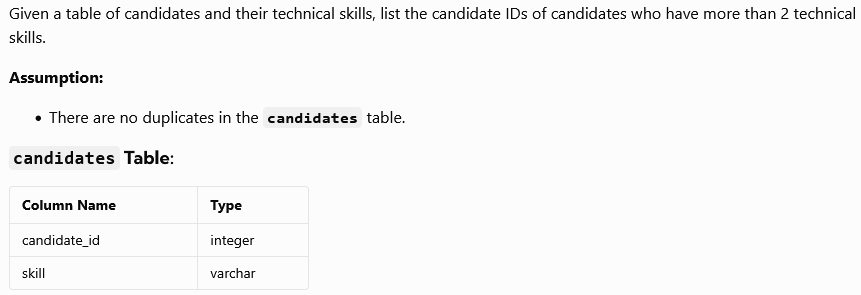

In [ ]:
"""
SELECT candidate_id
FROM candidates
GROUP BY candidate_id
HAVING COUNT(candidate_id) > 2;
"""

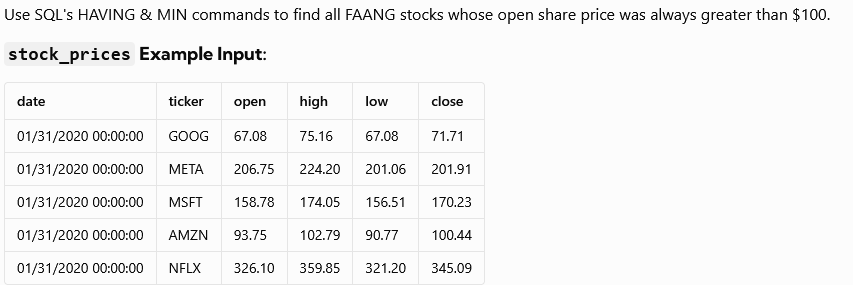

In [ ]:
"""
SELECT ticker, min(open)
FROM stock_prices
GROUP BY ticker
HAVING min(open) > 100
"""

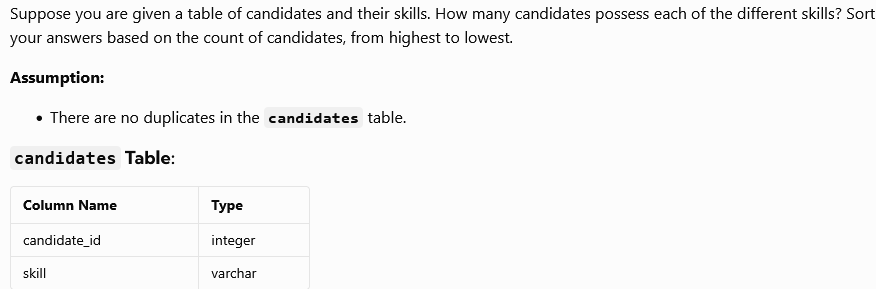

In [ ]:
"""
SELECT skill, COUNT(candidate_id) as count
FROM candidates
GROUP BY skill
ORDER BY count DESC;
"""

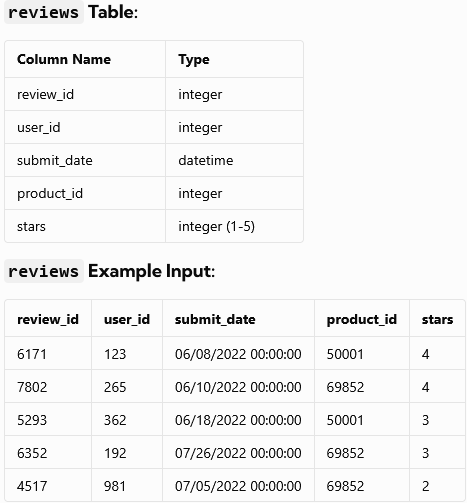

In [ ]:
"""
SELECT user_id, stars 
FROM reviews 
WHERE stars = 3;
"""

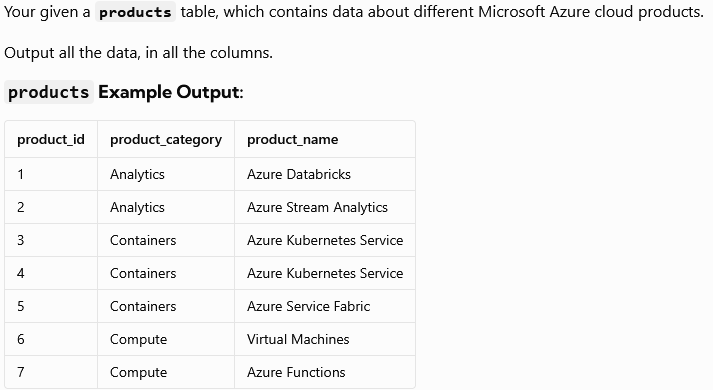

In [ ]:
SELECT * FROM products;

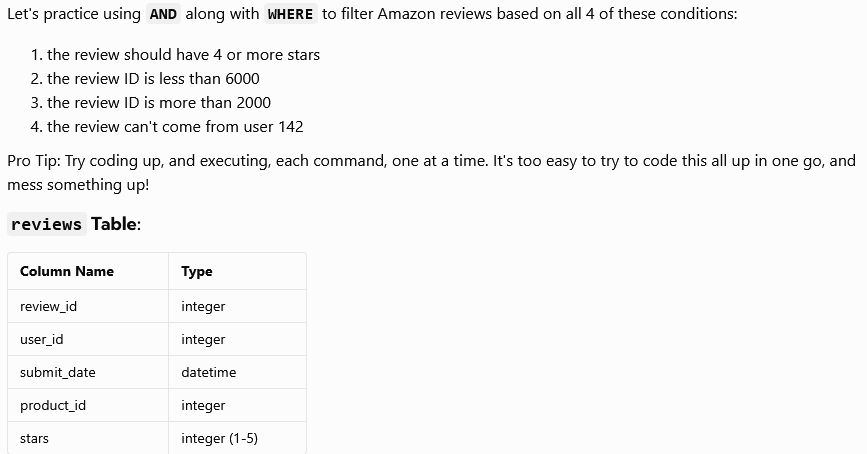

In [ ]:
SELECT *
FROM reviews
WHERE stars >= 4
  AND review_id < 6000
  AND review_id > 2000
  AND user_id != 142;

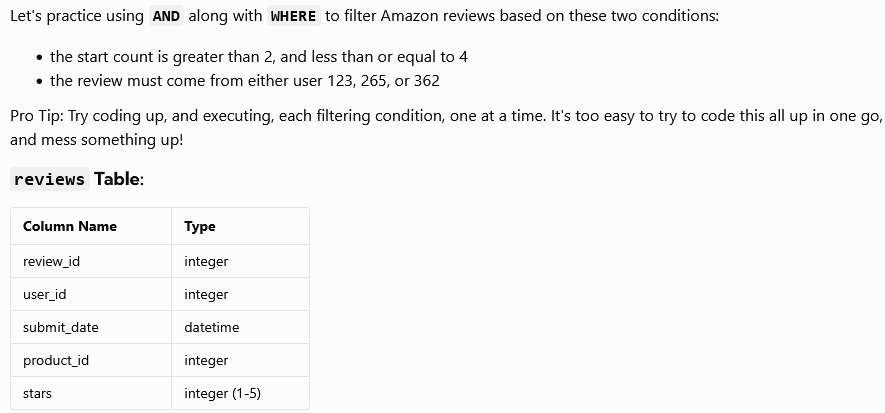

In [ ]:
SELECT *
FROM reviews
WHERE (stars > 2 AND stars <= 4)
  AND (user_id = 123 OR user_id = 265 OR user_id = 362);

# It can be done using IN statement:

SELECT *
FROM reviews
WHERE (stars IN (3, 4))
  AND (user_id IN (123, 265, 362))

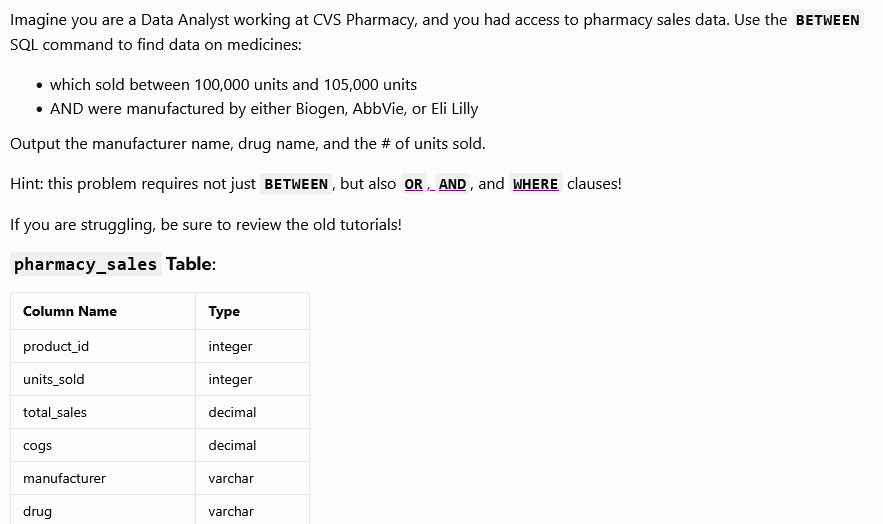

In [ ]:
SELECT manufacturer, drug, units_sold
FROM pharmacy_sales
WHERE units_sold BETWEEN 100000 AND 105000
  AND manufacturer in ('Biogen', 'AbbVie', 'Eli Lilly');

<!--- If we dumb it down to not include IN: --->

SELECT manufacturer, drug, units_sold
FROM pharmacy_sales
WHERE units_sold BETWEEN 100000 AND 105000
  AND (manufacturer = 'Biogen' OR manufacturer = 'AbbVie' OR manufacturer = 'Eli Lilly');

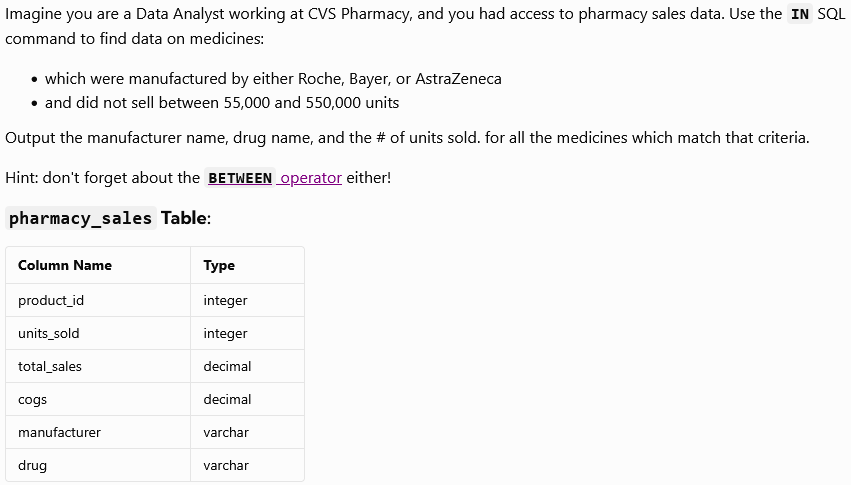

In [ ]:
SELECT manufacturer, drug, units_sold
FROM pharmacy_sales
WHERE manufacturer IN ('Roche', 'Bayer', 'AstraZeneca')
  AND units_sold NOT BETWEEN 55000 AND 550000;

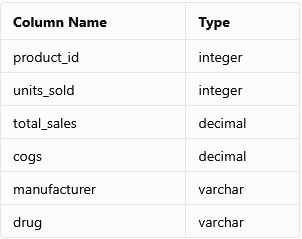

In [ ]:
SELECT drug, manufacturer, product_id
FROM pharmacy_sales
WHERE drug LIKE '%Relief%'
  OR drug LIKE '%relief%';

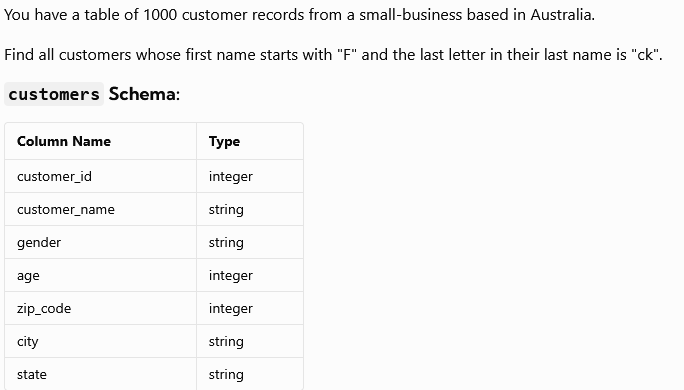

SELECT *
FROM customers
WHERE customer_name LIKE 'F%ck';

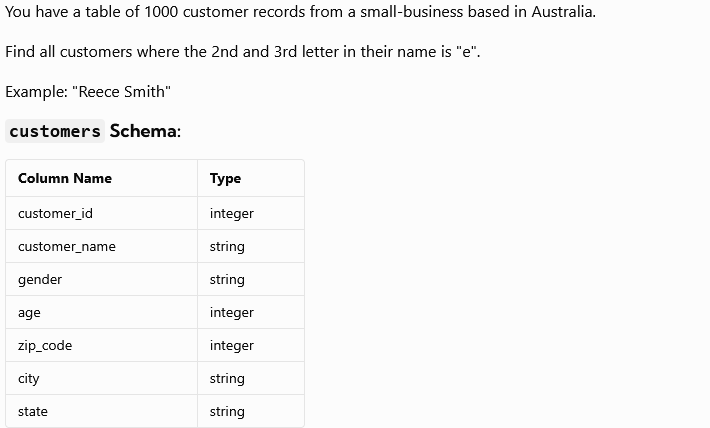

In [ ]:
SELECT *
FROM customers
WHERE customer_name LIKE '_ee%';

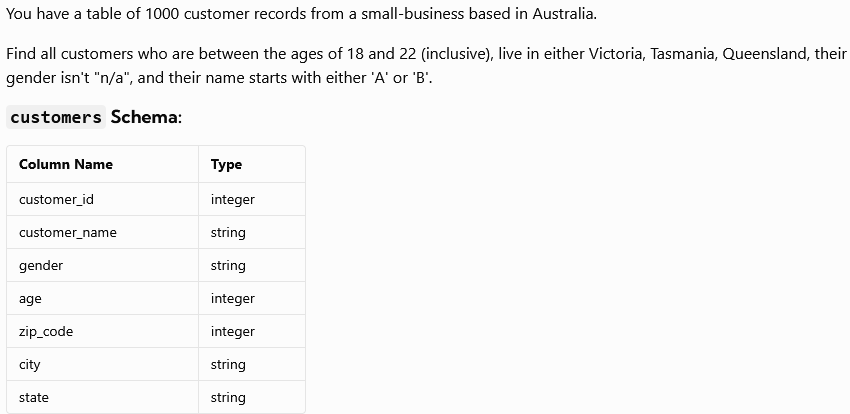

SELECT *
FROM customers
WHERE age between 18 AND 22
  AND state IN ('Victoria', 'Tasmania', 'Queensland')
  AND gender != 'n/a'
  AND (customer_name LIKE 'A%' OR customer_name LIKE 'B%');

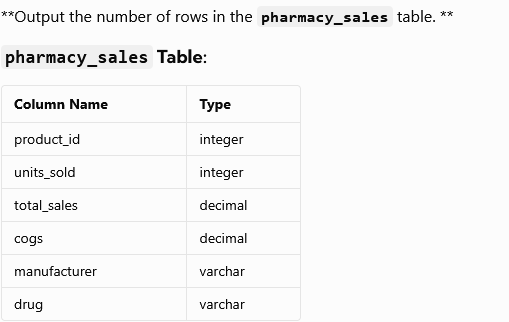

In [ ]:
SELECT COUNT(product_id)
FROM pharmacy_sales

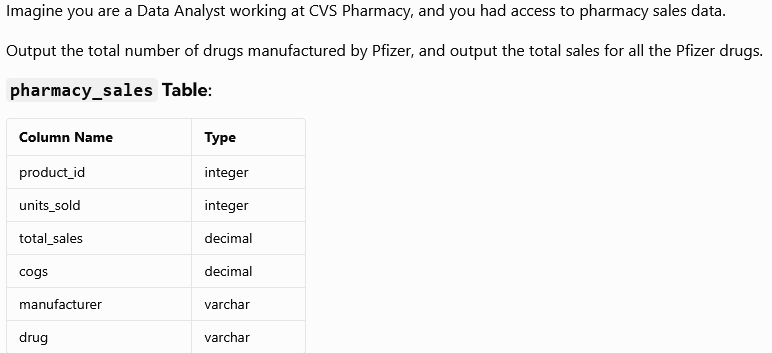

In [ ]:
SELECT COUNT(product_id), SUM(total_sales)
FROM pharmacy_sales
WHERE manufacturer = 'Pfizer'

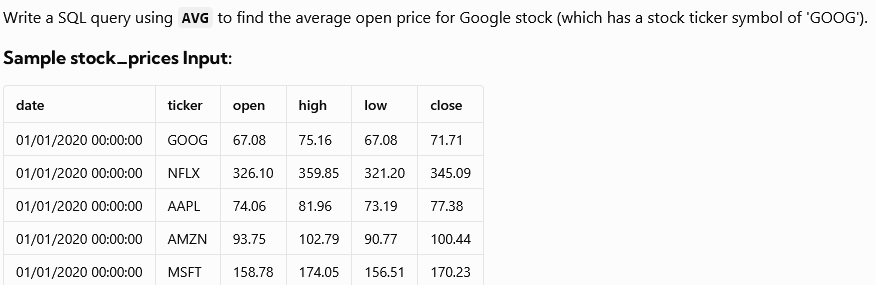

In [ ]:
SELECT AVG(open)
FROM stock_prices
WHERE ticker = 'GOOG'

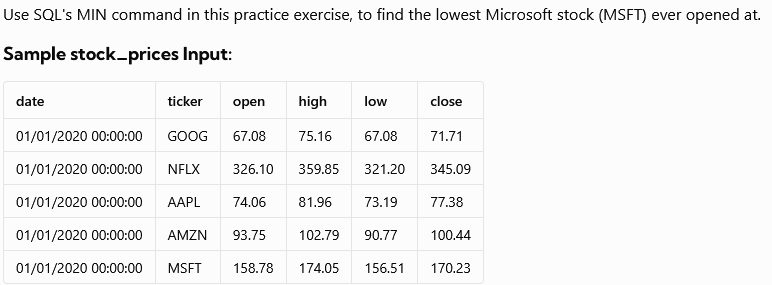

In [ ]:
SELECT MIN(open)
FROM stock_prices
WHERE ticker = 'MSFT'

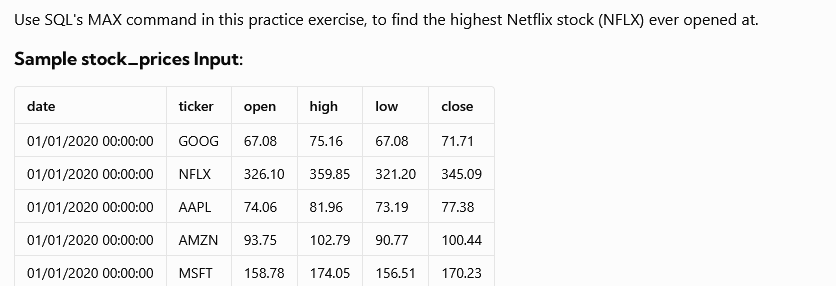

In [ ]:
SELECT MAX(open)
FROM stock_prices
WHERE ticker = 'NFLX'

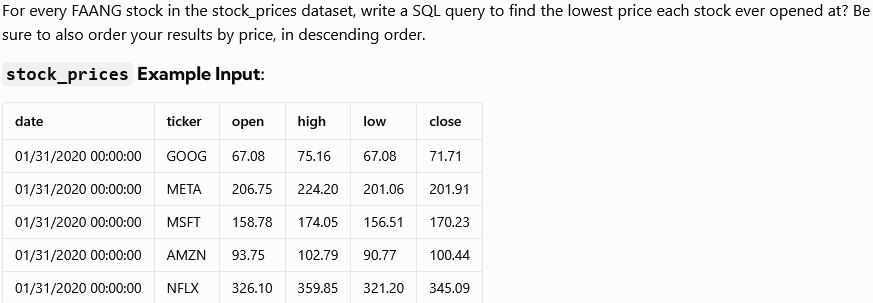

In [ ]:
SELECT ticker, MIN(open) as min_open
FROM stock_prices
GROUP BY ticker
ORDER BY min_open DESC;